<a href="https://colab.research.google.com/github/mohamedashraf111999/VIT/blob/main/ViT_Replicating_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3849, done.
remote: Counting objects: 100% (3849/3849), done.
remote: Compressing objects: 100% (1571/1571), done.
remote: Total 3849 (delta 2255), reused 3752 (delta 2217), pack-reused 0
Receiving objects: 100% (3849/3849), 647.06 MiB | 40.66 MiB/s, done.
Resolving deltas: 100% (2255/2255), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [5]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [6]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d232454f550>,
 ['pizza', 'steak', 'sushi'])

In [7]:
def plot_sample_img_for_dataloader(dataloader: torch.utils.data.DataLoader):
  """Visualize a sample Image from the dataloader.
  Args:
  dataloader: the dataloader the we need sample from
  Returns:
  No Return just visualizing image
  """
  img_batch, label_batch = next(iter(dataloader))
  sample_img, sample_label = img_batch[0], label_batch[0]
  plt.imshow(sample_img.permute(1, 2, 0))
  plt.title(class_names[sample_label])
  plt.axis("off")


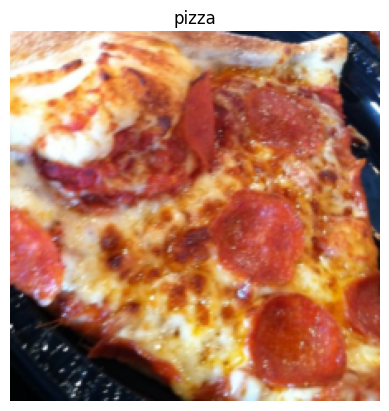

In [8]:
plot_sample_img_for_dataloader(dataloader= train_dataloader)

In [9]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [10]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


In [11]:
img_batch, label_batch = next(iter(train_dataloader))
sample_img, sample_label = img_batch[0], label_batch[0]

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


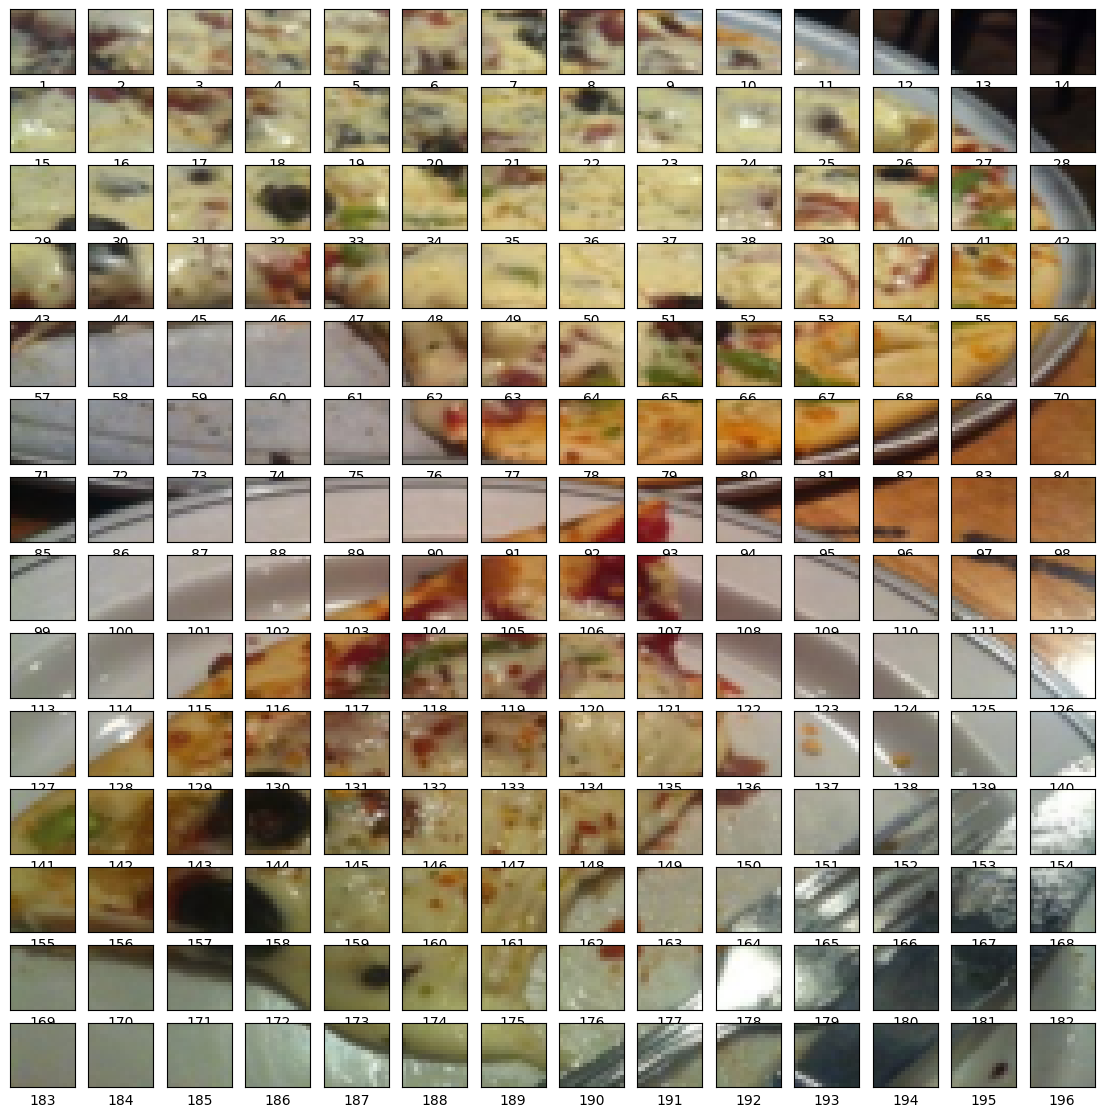

In [12]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
image_permuted = sample_img.permute(1, 2, 0)
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=int(num_patches),
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for row, row_patch in enumerate(range(0, img_size, patch_size)):

  for i, patch in enumerate(range(0, img_size, patch_size)):
      axs[row,i].imshow(image_permuted[row_patch:row_patch+patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
      axs[row,i].set_xlabel(i+1 + int(row*num_patches)) # set the label
      axs[row,i].set_xticks([])
      axs[row,i].set_yticks([])

In [13]:
from torch import nn


patch_size=16


conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

image_out_of_conv = conv2d(sample_img.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [64, 474, 723, 95, 581]


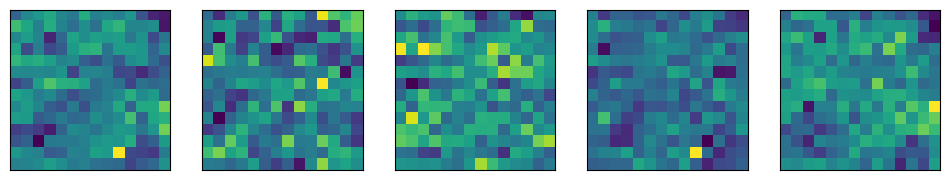

In [14]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [15]:
flatten = nn.Flatten(start_dim=2, end_dim=3)
image_out_of_flatten = flatten(image_out_of_conv)

image_out_of_flatten_permuted = image_out_of_flatten.permute(0, 2, 1)
image_out_of_flatten_permuted.shape

torch.Size([1, 196, 768])

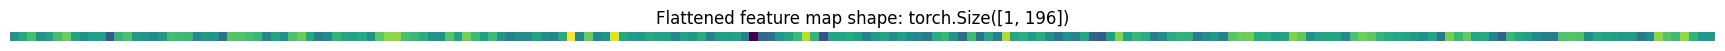

In [16]:
single_flattened_feature_map = image_out_of_flatten_permuted[:, :, 1] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [17]:
class PatchEmbedding(nn.Module):

  def __init__(self,
               in_channels:int = 3,
               patch_size:int = 16,
               embedding_dim:int= 768):
    super().__init__()


    self.patch_size = patch_size

    self.patcher = nn.Conv2d(in_channels= in_channels,
                             out_channels= embedding_dim,
                             kernel_size= patch_size,
                             stride= patch_size,
                             padding = 0)

    self.flatten = nn.Flatten(start_dim = 2,
                              end_dim = 3)

  def forward(self, x):
    image_reslution = x.shape[-1]
    assert image_reslution % patch_size ==0, f"Image size must be divisible by patch_size, Image_shape :{image_reslution}, Patch_size: {patch_size}"
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    return x_flattened.permute(0, 2, 1)


In [18]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {sample_img.unsqueeze(0).shape}")
patch_embedded_image = patchify(sample_img.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [19]:
rand_image_tensor = torch.rand(1, 3, 224, 224)

rand_image_tensor_bad = torch.rand(1, 3, 250, 250)


patchify(rand_image_tensor)

tensor([[[-0.6593,  0.0912, -0.1765,  ...,  0.2075, -0.2554,  0.1557],
         [-0.4664,  0.2626, -0.1843,  ..., -0.0550, -0.1587,  0.1954],
         [-0.4906,  0.1833, -0.1601,  ...,  0.6322, -0.1585,  0.0585],
         ...,
         [-0.6404,  0.1462, -0.3884,  ...,  0.5681, -0.1871,  0.4515],
         [-0.5264,  0.2209, -0.1268,  ...,  0.2466, -0.1717,  0.0054],
         [-0.3889, -0.0037, -0.2184,  ...,  0.1711,  0.0484,  0.0425]]],
       grad_fn=<PermuteBackward0>)

In [20]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [21]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.3284,  0.1915, -0.1139,  ...,  0.2737, -0.2133,  0.2203],
         [-0.5816,  0.1658,  0.0529,  ...,  0.5118, -0.3753,  0.0299],
         ...,
         [-0.3186,  0.0682, -0.0682,  ...,  0.2406, -0.1441,  0.0776],
         [-0.5008,  0.1046, -0.1635,  ...,  0.2812, -0.1282,  0.2113],
         [-0.5215,  0.2059, -0.1498,  ...,  0.4180, -0.2231,  0.1057]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [22]:
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.3284,  0.1915, -0.1139,  ...,  0.2737, -0.2133,  0.2203],
          [-0.5816,  0.1658,  0.0529,  ...,  0.5118, -0.3753,  0.0299],
          ...,
          [-0.3186,  0.0682, -0.0682,  ...,  0.2406, -0.1441,  0.0776],
          [-0.5008,  0.1046, -0.1635,  ...,  0.2812, -0.1282,  0.2113],
          [-0.5215,  0.2059, -0.1498,  ...,  0.4180, -0.2231,  0.1057]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [23]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [24]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.6716, 1.1915, 0.8861,  ..., 1.2737, 0.7867, 1.2203],
         [0.4184, 1.1658, 1.0529,  ..., 1.5118, 0.6247, 1.0299],
         ...,
         [0.6814, 1.0682, 0.9318,  ..., 1.2406, 0.8559, 1.0776],
         [0.4992, 1.1046, 0.8365,  ..., 1.2812, 0.8718, 1.2113],
         [0.4785, 1.2059, 0.8502,  ..., 1.4180, 0.7769, 1.1057]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [25]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output



In [26]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [27]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.6716, 1.1915, 0.8861,  ..., 1.2737, 0.7867, 1.2203],
         [0.4184, 1.1658, 1.0529,  ..., 1.5118, 0.6247, 1.0299],
         ...,
         [0.6814, 1.0682, 0.9318,  ..., 1.2406, 0.8559, 1.0776],
         [0.4992, 1.1046, 0.8365,  ..., 1.2812, 0.8718, 1.2113],
         [0.4785, 1.2059, 0.8502,  ..., 1.4180, 0.7769, 1.1057]]],
       grad_fn=<AddBackward0>)

In [28]:
patched_image_through_msa_block

tensor([[[ 0.7561, -0.5280,  0.1280,  ...,  0.3004,  0.7081, -0.0562],
         [ 0.7543, -0.5266,  0.1277,  ...,  0.2926,  0.7043, -0.0585],
         [ 0.7532, -0.5296,  0.1292,  ...,  0.2944,  0.7021, -0.0576],
         ...,
         [ 0.7547, -0.5282,  0.1287,  ...,  0.2936,  0.7047, -0.0586],
         [ 0.7529, -0.5264,  0.1285,  ...,  0.2912,  0.7060, -0.0581],
         [ 0.7536, -0.5283,  0.1284,  ...,  0.2924,  0.7029, -0.0582]]],
       grad_fn=<TransposeBackward0>)

In [29]:
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.activation import GELU
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               mlp_size: int = 3072,
               dropout: float= 0.1):
     super().__init__()

     self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

     self.mlp= nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p= dropout),
        nn.Linear(in_features=mlp_size,
                  out_features= embedding_dim),
        nn.Dropout(p= dropout)
     )
  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)

    return x



In [30]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [31]:
patched_image_through_msa_block

tensor([[[ 0.7561, -0.5280,  0.1280,  ...,  0.3004,  0.7081, -0.0562],
         [ 0.7543, -0.5266,  0.1277,  ...,  0.2926,  0.7043, -0.0585],
         [ 0.7532, -0.5296,  0.1292,  ...,  0.2944,  0.7021, -0.0576],
         ...,
         [ 0.7547, -0.5282,  0.1287,  ...,  0.2936,  0.7047, -0.0586],
         [ 0.7529, -0.5264,  0.1285,  ...,  0.2912,  0.7060, -0.0581],
         [ 0.7536, -0.5283,  0.1284,  ...,  0.2924,  0.7029, -0.0582]]],
       grad_fn=<TransposeBackward0>)

In [32]:
patched_image_through_mlp_block

tensor([[[-0.5007, -0.4099,  0.0000,  ..., -0.0939, -0.4027,  0.1348],
         [-0.0000, -0.3309,  0.0967,  ..., -0.0529, -0.4598,  0.2308],
         [-0.0000, -0.4008,  0.1643,  ..., -0.0721, -0.4029,  0.0000],
         ...,
         [-0.0000, -0.3694,  0.1478,  ..., -0.0922, -0.3510,  0.2153],
         [-0.3252, -0.3483,  0.0676,  ...,  0.0591, -0.4155,  0.1368],
         [-0.4795, -0.3894,  0.0236,  ..., -0.0000, -0.4648,  0.3403]]],
       grad_fn=<MulBackward0>)

In [33]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [34]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [35]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [36]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [37]:
class ViT(nn.Module):
  def __init__(self,
               in_channels: int = 3,
               img_size: int = 224,
               patch_size: int = 16,
               num_transformer_layers: int = 12,
               embedding_dim: int = 768,
               mlp_size: int = 3072,
               num_heads: int = 12,
               attn_dropout: int = 0,
               mlp_dropout: int = 0.1,
               embedding_dropout: int = 0.1,
               num_class: int = 1000) -> None:
     super().__init__()

     assert img_size % patch_size ==0, f"Image size must me divisible by patch_size, image : {img_size}, patch: {patch_size}"

     self.num_patches = (img_size * img_size) // patch_size **2


     self.class_embeding = nn.Parameter(data= torch.randn(1, 1, embedding_dim), requires_grad= True)


     self.position_embedding = nn.Parameter(data = torch.randn(1, self.num_patches+1, embedding_dim))

     self.embeding_dropout = nn.Dropout(p = embedding_dropout)

     self.patch_embedding = PatchEmbedding(in_channels= in_channels,
                                           patch_size= patch_size,
                                           embedding_dim= embedding_dim)

     self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim= embedding_dim,
                                                                        num_heads= num_heads,
                                                                        mlp_size= mlp_size,
                                                                        mlp_dropout= mlp_dropout) for _ in range(num_transformer_layers)] )


     self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
                     nn.Linear(in_features= embedding_dim,
                               out_features=num_class))


  def forward(self, x):
    patch_size = x.shape[0]
    class_token = self.class_embeding.expand(patch_size, -1, -1)
    x= self.patch_embedding(x)
    x = torch.cat((class_token, x), dim = 1)
    x = x + self.position_embedding
    x = self.embeding_dropout(x)
    x = self.transformer_encoder(x)
    x= self.classifier(x[:, 0])
    return x



In [38]:
vit = ViT()

vit

ViT(
  (embeding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiheadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
   

In [39]:
set_seeds()

rand_img = torch.randn(1, 3, 224, 224)

vit = ViT(num_class= len(class_names))

vit(rand_img)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [40]:
from torchinfo import summary

 # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
 )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embeding_dropout)                                 [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [41]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1948 | train_acc: 0.3633 | test_loss: 5.1218 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9518 | train_acc: 0.3320 | test_loss: 1.6203 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2073 | train_acc: 0.4570 | test_loss: 1.7584 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2482 | train_acc: 0.2969 | test_loss: 1.3214 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1331 | train_acc: 0.4297 | test_loss: 1.2293 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1787 | train_acc: 0.3125 | test_loss: 1.2244 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2512 | train_acc: 0.2578 | test_loss: 1.2060 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1147 | train_acc: 0.4258 | test_loss: 1.1859 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1458 | train_acc: 0.3047 | test_loss: 1.0135 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2647 | train_acc: 0.2617 | test_loss: 1.3921 | test_acc: 0.2604


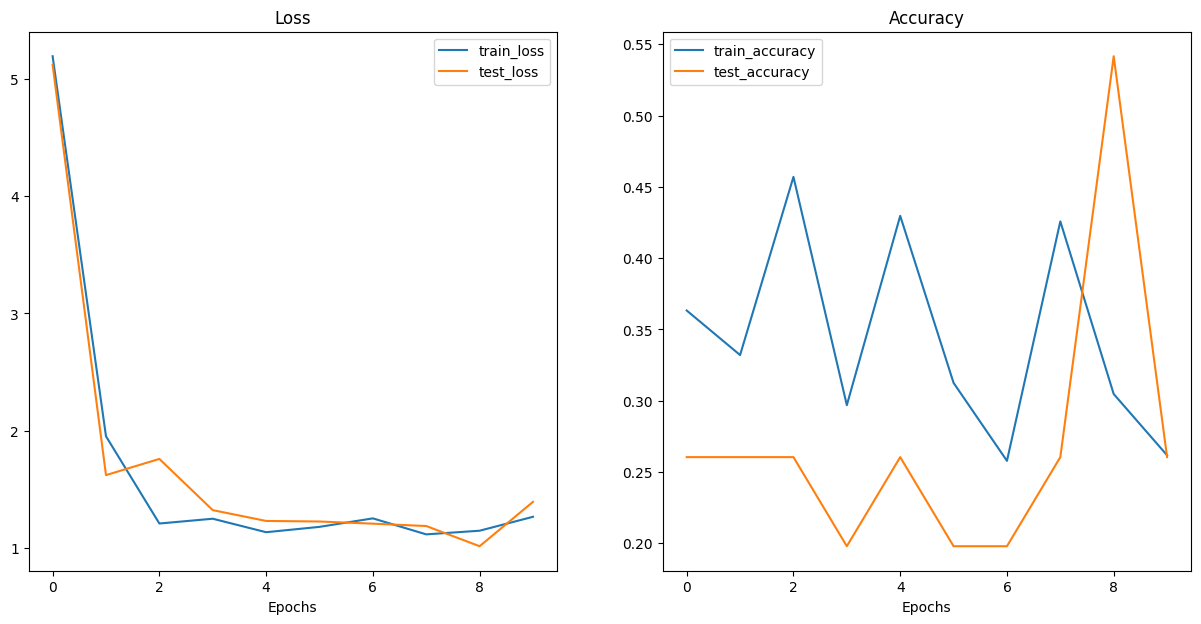

In [42]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

In [43]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 241MB/s]


In [ ]:
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [44]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [45]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

In [46]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176


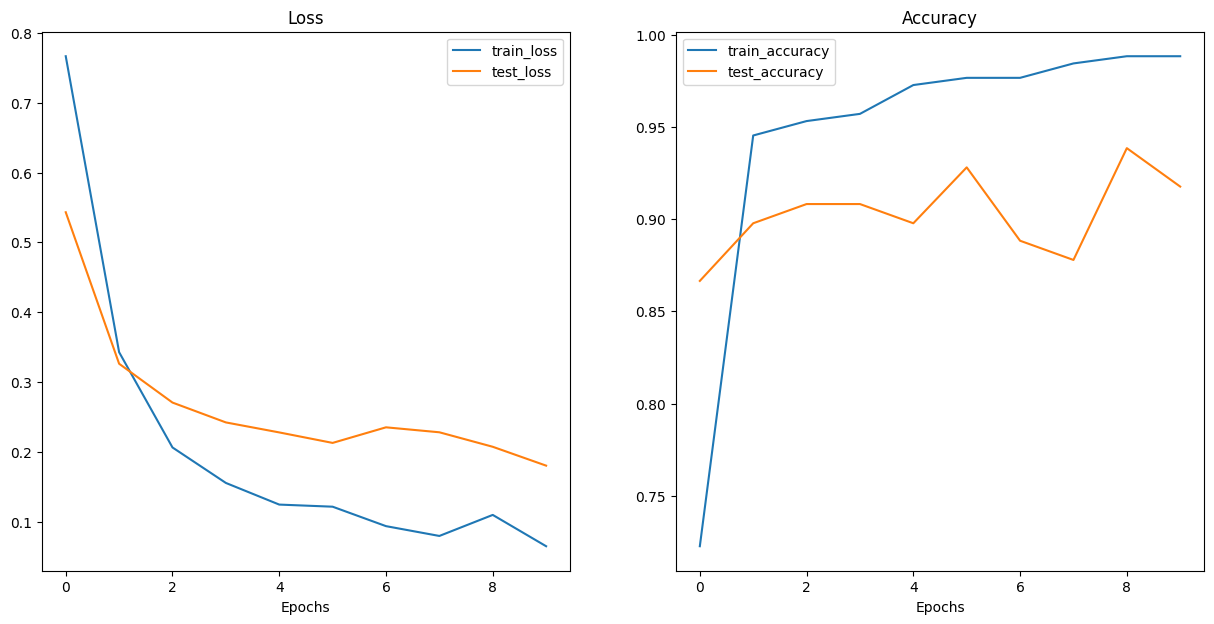

In [47]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [48]:
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth
